<a href="https://colab.research.google.com/github/RoMoRoToR/Article_on_pH_recognition/blob/master/working_with_phone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [104]:
def generate_image(filename, min_dist, edge_threshold, centre_threshold, min_radius, max_radius):
    src = cv2.imread(cv2.samples.findFile(filename), cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 5)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, min_dist,
                              param1=edge_threshold, param2=centre_threshold,
                              minRadius=min_radius, maxRadius=max_radius)
    circle_coords = None
    if circles is not None:
        circles = np.uint16(np.around(circles))

        # Найти самый большой круг
        max_radius = 0
        for i in circles[0, :]:
            if i[2] > max_radius:
                max_radius = i[2]
                circle_coords = (i[0], i[1], i[2])

        # Нарисовать только центр круга
        if circle_coords is not None:
            center = (int(circle_coords[0]), int(circle_coords[1]))
            radius = int(circle_coords[2] * 0.2)  # Уменьшить радиус круга до 20% от оригинального
            cv2.circle(src, center, radius, (0, 100, 100), 3)

    text_loc = (100, 100)
    inverted_color = (int(255 - src[text_loc][0]), int(255 - src[text_loc][1]), int(255 - src[text_loc][2]))
    cv2.putText(src, "{} circles".format(len(circles[0])), text_loc, cv2.FONT_HERSHEY_SIMPLEX, 1.5, inverted_color)

    return src, circle_coords


In [105]:
def gray_world_balance(image):
    avg_bgr = np.mean(image, axis=(0, 1))
    gain = np.mean(avg_bgr) / avg_bgr
    white_balanced_img = (image * gain).clip(0, 255).astype(np.uint8)
    return white_balanced_img

In [106]:
def convert_to_lab_and_normalize(image):
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    l, a, b = cv2.split(lab_image)
    l[:] = 50
    normalized_lab = cv2.merge([l, a, b])
    return cv2.cvtColor(normalized_lab, cv2.COLOR_Lab2BGR)

In [107]:
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab[:, :, 0] = clahe.apply(lab[:, :, 0])
    return cv2.cvtColor(lab, cv2.COLOR_Lab2BGR)

In [108]:
# Словарь с данными
test_samples_lab = {
    (216, 179): 8.0,
    (172, 152): 7.7,
    (171, 161): 7.5,
    (163, 183): 7.2,
    (192, 205): 6.9,
    (150, 195): 6.5,
    (181, 215): 6.3,
    (118, 188): 6.0,
    (114, 203): 5.7,
}

In [151]:
# Загрузка изображения
image_path = '7.2.png'
image = cv2.imread(image_path)

In [152]:
# Применение предобработки
white_balanced_image = gray_world_balance(image)
lab_normalized_image = convert_to_lab_and_normalize(white_balanced_image)
final_image = apply_clahe(lab_normalized_image)

In [153]:
# Получение изображения с выделенным центром круга и его координатами
image_with_circle, circle_coords = generate_image(image_path, min_dist=50, edge_threshold=50, centre_threshold=50, min_radius=0, max_radius=0)


Estimated pH: 7.20


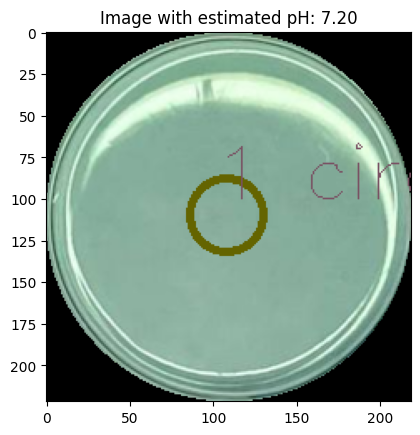

In [154]:
if circle_coords is not None:
    circle_x, circle_y, circle_radius = circle_coords
    # Получение цвета пикселя в центре круга
    circle_center_color = image_with_circle[int(circle_y), int(circle_x)]

    # Поиск ближайшего значения pH
    distances = np.linalg.norm(np.array(list(test_samples_lab.keys())) - circle_center_color[:2], axis=1)
    nearest_index = np.argmin(distances)
    nearest_ph_value = list(test_samples_lab.values())[nearest_index]

    print(f"Estimated pH: {nearest_ph_value:.2f}")

    # Визуализация результатов
    plt.imshow(cv2.cvtColor(image_with_circle, cv2.COLOR_BGR2RGB))
    plt.title(f'Image with estimated pH: {nearest_ph_value:.2f}')
    plt.show()
else:
    print("Circle not found in the image.")

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy.interpolate import griddata

In [ ]:
def correct_white_balance(image):
    """Коррекция баланса белого по методу серого мира."""
    img_float = image.astype(np.float32)
    mean_r = np.mean(img_float[:,:,2])
    mean_g = np.mean(img_float[:,:,1])
    mean_b = np.mean(img_float[:,:,0])
    mean_gray = (mean_r + mean_g + mean_b) / 3
    img_float[:,:,2] *= (mean_gray / mean_r)
    img_float[:,:,1] *= (mean_gray / mean_g)
    img_float[:,:,0] *= (mean_gray / mean_b)
    np.clip(img_float, 0, 255, out=img_float)
    return img_float.astype(np.uint8)

In [ ]:
# Загрузка изображения
image_path = '5.7.jpg'
image = cv2.imread(image_path)
image_corrected = correct_white_balance(image)  # Применение коррекции баланса белого

In [ ]:
# Преобразование в серый цвет и применение гауссова размытия
gray = cv2.cvtColor(image_corrected, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (9, 9), 0)

Средний цвет центральной части круга: (150.4632558139535, 181.30245847176081, 187.71787375415283)


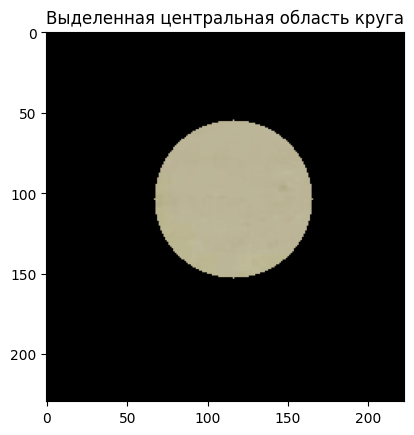

In [ ]:
# Обнаружение кругов с уменьшенным радиусом
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, param1=50, param2=30, minRadius=10, maxRadius=100)
mean_color = None
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        mask = np.zeros(gray.shape, dtype="uint8")
        cv2.circle(mask, (x, y), r // 2, 255, -1)  # Маска для центральной части круга
        mean_val = cv2.mean(image_corrected, mask=mask)[:3]  # Исключаем альфа-канал
        print("Средний цвет центральной части круга:", mean_val)
        masked_image = cv2.bitwise_and(image_corrected, image_corrected, mask=mask)
        plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
        plt.title('Выделенная центральная область круга')
        plt.show()
        mean_color = mean_val
else:
    print("Круги не обнаружены.")

In [ ]:
# Данные образцов для pH и соответствующих цветов
test_samples = {
    (216, 179, 61): 8.0,
    (172, 152, 37): 7.7,
    (171, 161, 45): 7.5,
    (163, 183, 145): 7.2,
    (192, 205, 200): 6.9,
    (150, 195, 195): 6.5,
    (181, 215, 217): 6.3,
    (118, 188, 199): 6.0,
    (114, 203, 222): 5.7,
}

In [ ]:
# Оценка pH
if mean_color is not None:
    points = np.array(list(test_samples.keys()))
    values = np.array(list(test_samples.values()))
    estimated_ph = griddata(points, values, [mean_color], method='nearest')[0]
    print("Оценочное значение pH:", estimated_ph)
else:
    print("Невозможно оценить pH: нет среднего цвета.")

Оценочное значение pH: 6.5
